In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [3]:
train_images = pd.read_csv("/content/drive/My Drive/Radio Signals/train/images.csv",header=None)
train_labels = pd.read_csv("/content/drive/My Drive/Radio Signals/train/labels.csv",header=None)

val_images = pd.read_csv("/content/drive/My Drive/Radio Signals/validation/images.csv",header=None)
val_labels = pd.read_csv("/content/drive/My Drive/Radio Signals/validation/labels.csv",header=None)

print(train_images.shape,train_labels.shape)
print(val_images.shape,val_labels.shape)

(3200, 8192) (3200, 4)
(800, 8192) (800, 4)


In [4]:
train_images.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,8152,8153,8154,8155,8156,8157,8158,8159,8160,8161,8162,8163,8164,8165,8166,8167,8168,8169,8170,8171,8172,8173,8174,8175,8176,8177,8178,8179,8180,8181,8182,8183,8184,8185,8186,8187,8188,8189,8190,8191
0,0.631373,0.623529,0.713726,0.705882,0.658824,0.666667,0.654902,0.635294,0.647059,0.705882,0.729412,0.725490,0.619608,0.674510,0.643137,0.705882,0.713726,0.658824,0.615686,0.690196,0.654902,0.525490,0.556863,0.541176,0.482353,0.588235,0.615686,0.600000,0.603922,0.627451,0.678431,0.658824,0.698039,0.576471,0.678431,0.686275,0.690196,0.705882,0.705882,0.643137,...,0.650980,0.666667,0.666667,0.709804,0.682353,0.682353,0.682353,0.658824,0.682353,0.643137,0.627451,0.623529,0.650980,0.721569,0.627451,0.635294,0.709804,0.690196,0.678431,0.647059,0.658824,0.682353,0.654902,0.694118,0.741176,0.678431,0.662745,0.729412,0.694118,0.647059,0.682353,0.611765,0.650980,0.658824,0.600000,0.603922,0.654902,0.694118,0.658824,0.666667
1,0.725490,0.752941,0.749020,0.701961,0.690196,0.721569,0.709804,0.745098,0.654902,0.721569,0.678431,0.709804,0.713726,0.686275,0.717647,0.713726,0.694118,0.690196,0.721569,0.701961,0.698039,0.713726,0.705882,0.756863,0.756863,0.694118,0.650980,0.674510,0.752941,0.725490,0.725490,0.760784,0.678431,0.717647,0.725490,0.682353,0.709804,0.729412,0.721569,0.717647,...,0.686275,0.670588,0.713726,0.733333,0.725490,0.694118,0.694118,0.686275,0.674510,0.729412,0.721569,0.701961,0.682353,0.709804,0.756863,0.698039,0.729412,0.721569,0.674510,0.698039,0.725490,0.733333,0.666667,0.682353,0.701961,0.737255,0.745098,0.725490,0.698039,0.650980,0.721569,0.698039,0.721569,0.686275,0.713726,0.682353,0.690196,0.698039,0.701961,0.725490
2,0.717647,0.701961,0.713726,0.733333,0.705882,0.717647,0.725490,0.682353,0.717647,0.674510,0.690196,0.670588,0.662745,0.666667,0.713726,0.701961,0.721569,0.713726,0.662745,0.698039,0.682353,0.639216,0.717647,0.658824,0.674510,0.639216,0.643137,0.635294,0.654902,0.682353,0.639216,0.733333,0.690196,0.658824,0.686275,0.658824,0.690196,0.698039,0.709804,0.650980,...,0.533333,0.572549,0.537255,0.549020,0.670588,0.690196,0.670588,0.643137,0.662745,0.713726,0.717647,0.721569,0.709804,0.674510,0.709804,0.686275,0.658824,0.694118,0.698039,0.694118,0.678431,0.678431,0.690196,0.662745,0.650980,0.650980,0.686275,0.631373,0.666667,0.701961,0.709804,0.694118,0.705882,0.682353,0.639216,0.713726,0.670588,0.678431,0.737255,0.674510
3,0.705882,0.674510,0.654902,0.678431,0.666667,0.662745,0.678431,0.662745,0.686275,0.686275,0.631373,0.650980,0.670588,0.737255,0.674510,0.615686,0.670588,0.705882,0.686275,0.678431,0.694118,0.647059,0.662745,0.682353,0.654902,0.721569,0.709804,0.631373,0.670588,0.674510,0.701961,0.725490,0.666667,0.647059,0.733333,0.682353,0.678431,0.603922,0.666667,0.713726,...,0.670588,0.705882,0.749020,0.662745,0.564706,0.623529,0.674510,0.709804,0.658824,0.631373,0.705882,0.670588,0.658824,0.690196,0.674510,0.658824,0.635294,0.682353,0.682353,0.639216,0.666667,0.654902,0.647059,0.670588,0.682353,0.639216,0.705882,0.729412,0.674510,0.666667,0.639216,0.662745,0.631373,0.643137,0.705882,0.662745,0.705882,0.666667,0.654902,0.631373
4,0.647059,0.729412,0.701961,0.674510,0.611765,0.698039,0.713726,0.662745,0.701961,0.674510,0.631373,0.709804,0.694118,0.698039,0.666667,0.690196,0.690196,0.682353,0.682353,0.647059,0.678431,0.658824,0.760784,0.729412,0.674510,0.694118,0.698039,0.713726,0.690196,0.698039,0.686275,0.705882,0.662745,0.670588,0.705882,0.682353,0.690196,0.733333,0.709804,0.701961,...,0.639216,0.690196,0.662745,0.658824,0.662745,0.698039,0.603922,0.690196,0.627451,0.627451,0.654902,0.725490,0.650980,0.717647,0.666667,0.709804,0.682353,0.674510,0.721569,0.741176,0.635294,0.615686,0.674510,0.690196,0.658824,0.694118,0.701961,0.670588,0.721569,0.780392,0.639216,0.670588,0.705882,0.674510,0.721569,0.694118,0.674510,0.705882,0.749020,0.729412


In [5]:
X_train = train_images.values.reshape(3200,64,128,1)
X_test = val_images.values.reshape(800, 64, 128, 1)

y_train = train_labels.values
y_test = val_labels.values

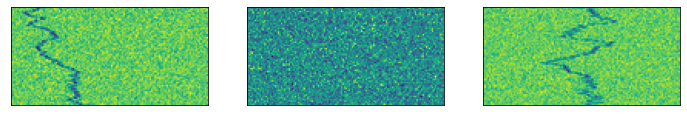

In [6]:
plt.figure(0, figsize=(12,12))
for i in range(1,4):
   plt.subplot(1,3,i)
   img = np.squeeze(X_train[np.random.randint(0, X_train.shape[0])])
   plt.xticks([])
   plt.yticks([])
   plt.imshow(img)

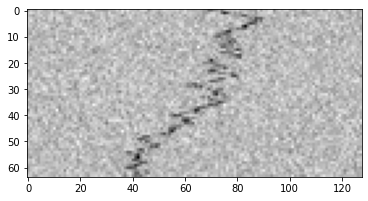

In [7]:
plt.imshow(np.squeeze(X_train[133]), cmap="gray")

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(horizontal_flip=True)
train_datagen.fit(X_train)

val_datagen = ImageDataGenerator(horizontal_flip=True)
val_datagen.fit(X_train)

In [9]:
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

In [17]:
model = Sequential()

model.add(Conv2D(64,(5,5), padding="same", input_shape=(X_train[0].shape)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(128,(3,3), padding="same"))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(256,(3,3),padding="same"))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(1024))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.4))
model.add(Dense(4, activation="softmax"))

In [18]:
initial_learning_rate = 0.005
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                         initial_learning_rate = initial_learning_rate,
                         decay_steps=5,
                         decay_rate=0.96,
                         staircase=True)
optimizer = Adam(learning_rate=lr_schedule)

In [19]:
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 64, 128, 64)       1664      
_________________________________________________________________
batch_normalization_4 (Batch (None, 64, 128, 64)       256       
_________________________________________________________________
activation (Activation)      (None, 64, 128, 64)       0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 64, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 32, 64, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 64, 128)       73856     
_________________________________________________________________
batch_normalization_5 (Batch (None, 32, 64, 128)      

In [20]:
#pip install livelossplot

In [21]:
from livelossplot.inputs.tf_keras import PlotLossesCallback

In [22]:
checkpoint = ModelCheckpoint("model_weights.h5",save_weights_only=True, monitor="val_loss", mode="min",verbose=0)
callbacks = [PlotLossesCallback(), checkpoint]
batch_size = 32

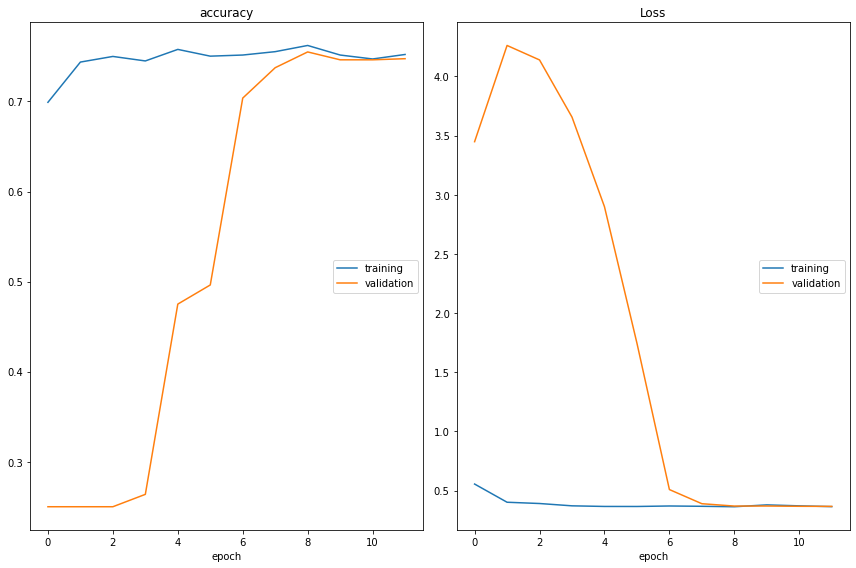

accuracy
	training         	 (min:    0.699, max:    0.762, cur:    0.752)
	validation       	 (min:    0.250, max:    0.755, cur:    0.748)
Loss
	training         	 (min:    0.364, max:    0.556, cur:    0.365)
	validation       	 (min:    0.367, max:    4.261, cur:    0.367)
100/100 [==============================] - 6s 58ms/step - loss: 0.3649 - accuracy: 0.7522 - val_loss: 0.3669 - val_accuracy: 0.7475


In [23]:
history = model.fit(train_datagen.flow(X_train,y_train,batch_size=batch_size, shuffle=True),
                    steps_per_epoch=len(X_train)//batch_size,
                    validation_data=val_datagen.flow(X_test,y_test,batch_size=batch_size,shuffle=True),
                    validation_steps=len(X_test)//batch_size,
                    epochs=12,
                    callbacks=callbacks)

In [25]:
model.evaluate(X_test,y_test)

25/25 [==============================] - 0s 13ms/step - loss: 0.3673 - accuracy: 0.7462


[0.36725914478302, 0.7462499737739563]

In [28]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import seaborn as sns

y_true = np.argmax(y_test, 1)
y_pred = np.argmax(model.predict(X_test), 1)
print(metrics.classification_report(y_true, y_pred))
print("Classification accuracy: %0.6f" % metrics.accuracy_score(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98       200
           1       0.50      0.31      0.38       200
           2       0.50      0.70      0.59       200
           3       1.00      1.00      1.00       200

    accuracy                           0.75       800
   macro avg       0.75      0.75      0.74       800
weighted avg       0.75      0.75      0.74       800

Classification accuracy: 0.746250


[Text(0, 0.5, 'squiggle'),
 Text(0, 1.5, 'narrowband'),
 Text(0, 2.5, 'noise'),
 Text(0, 3.5, 'narrowbanddrd')]

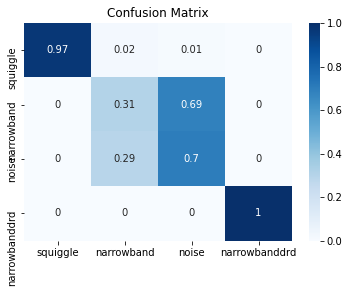

In [30]:
labels = ["squiggle", "narrowband", "noise", "narrowbanddrd"]
ax= plt.subplot()
sns.heatmap(metrics.confusion_matrix(y_true, y_pred, normalize='true'), annot=True, ax = ax, cmap=plt.cm.Blues)
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)